# Color Transfer between Images

https://www.cs.tau.ac.il/~turkel/imagepapers/ColorTransfer.pdf

In [1]:
import numpy as np  
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
# SOURCE ='../input/Set14/lenna.png' 
# SOURCE ='../input/Set14/baboon.png' 
# TARGET = '../input/Set14/baboon.png'
# TARGET = '../input/Set14/monarch.png'
SOURCE='../input/img6.jpg'
TARGET='../input/img5.jpg'

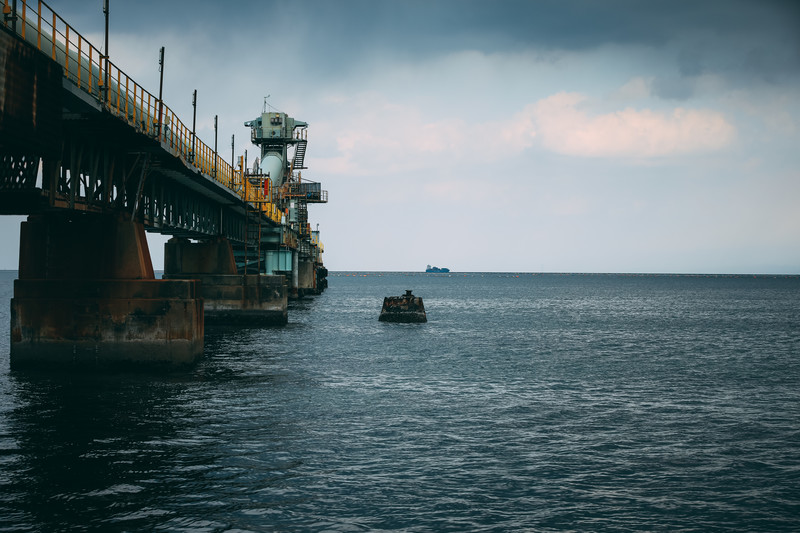

In [3]:
source = Image.open(SOURCE)
source

画像はぱくたそ(https://www.pakutaso.com/) からお借りした.

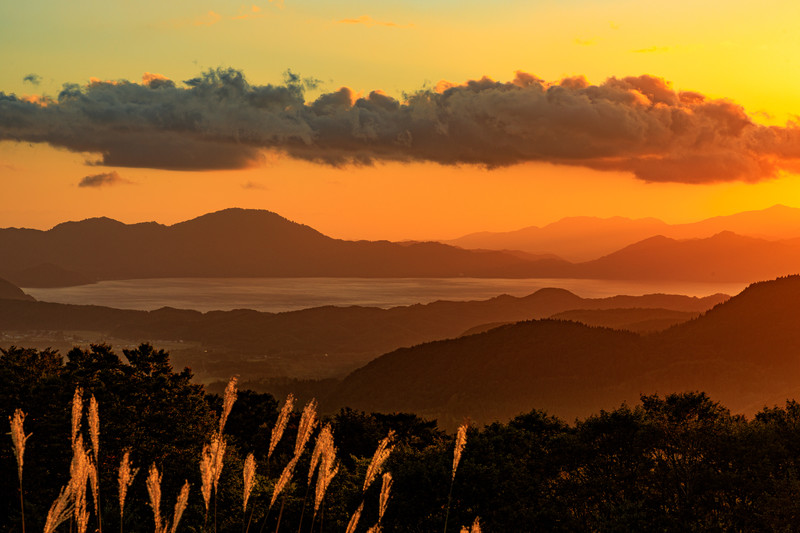

In [4]:
target = Image.open(TARGET)
target

In [5]:
target=target.resize(source.size)

In [6]:
source = np.asarray(source)
target = np.asarray(target)

In [7]:
# def trans_lab(array):
    
#     t_lms = np.array([
#         [0.3811, 0.5783, 0.0402],
#         [0.1967, 0.7244, 0.0782],
#         [0.0241, 0.1288, 0.8444],
#     ])
#     lms = np.dot(array, t_lms.T)
#     lms_log = np.log10(lms)
    
#     # lms to lab
#     t_lab = np.dot([
#         [1/np.sqrt(3), 0, 0],
#         [0, 1/np.sqrt(6), 0],
#         [0, 0, 1/np.sqrt(2)]
#             ],
#                 [
#                     [1, 1, 1],
#                     [1, 1, -2],
#                     [1, -1, 0],
#             ]
#     )
#     return np.dot(lms_log, t_lab.T)

# def reverse_rgb(array):
#     # t_lab の逆行列
#     revt_lms = np.dot([
#             [1, 1, 1],
#             [1, 1, -1],
#             [1, -2, 0]
#         ],
#             [
#                 [np.sqrt(3)/3, 0, 0],
#                 [0, np.sqrt(6)/6, 0],
#                 [0, 0, np.sqrt(2)/2],
#         ]
#     )
#     rev_lms = np.dot(array, revt_lms.T)
#     rev_lms = 10**rev_lms# np.exp(rev_lms)
    
#     # lms to rgb
#     revt_rgb = np.array([
#         [4.4679, -3.5873, 0.1193],
#         [-1.2186, 2.3809, -0.1624],
#         [0.0497, -0.2439, 1.2045]
#     ])
#     rev_rgb = np.dot(rev_lms, revt_rgb.T)

#     rev_rgb = np.clip(rev_rgb, 0, 255).astype(np.uint8)
#     return  rev_rgb

In [8]:
# https://qiita.com/wkiino/items/f4a8f340016951107646 を参考にしたコード
# RGB  と sRGB の違いがよくわからず.

M_RGB = np.array([
    [3.240479, -1.537150, -0.498535],
    [-0.969256, 1.875992, 0.041556],
    [0.055648, -0.204043, 1.057311]
])
T_LMS = np.array([
    [0.3897, 0.6890, -0.0787],
    [-0.2298, 1.1834, 0.0464],
    [0.0, 0.0, 1.0],
])
T_LAB = np.dot(np.array([
    [1/np.sqrt(3), 0, 0],
    [0, 1/np.sqrt(6), 0],
    [0, 0, 1/np.sqrt(2)]
]),
  np.array(  [
    [1, 1, 1],
    [1, 1, -2],
    [1, -1, 0],
])
)


def trans_lab(array):
    array = array.copy()/255
    array = np.where(array <= 0.04045, array/12.92, np.power((array+0.055)/1.055,2.4))

    lms = np.dot(array, np.dot(T_LMS, np.linalg.inv(M_RGB)).T)
    lms_log = np.log(lms)

    return np.dot(lms_log, T_LAB.T)


def reverse_rgb(array):
    v = np.dot(array, np.linalg.inv(T_LAB).T)
    v = np.exp(v)

    # lms to rgb
    v = np.dot(v, np.linalg.inv(T_LMS).T)
    v = np.dot(v, M_RGB.T)
    v = np.where(v <= 0.0031308, v*12.92, 1.055*np.power(v, 1/2.4) - 0.055)

    rev_rgb = (np.clip(v, 0, 1)*255).astype(np.uint8)
    return rev_rgb

In [9]:
import cv2
def read_file(sn):
    s1 = cv2.imread(sn)
    s1 = cv2.cvtColor(s1,cv2.COLOR_BGR2LAB)
    return s1

自作の lab 変換だと黄みがかった画像になったので, ここでは cv2.cvtColor で変換.

In [10]:
# lab_s = trans_lab(source)
# lab_t = trans_lab(target)

lab_s = read_file(SOURCE)
lab_t = read_file(TARGET)

###  変換の流れ

source を各次元で標準化し, それにtarget の標準偏差をかけて, target の分布に近い感じにするイメージ.
次に target の平均値をかけてあげる.

In [11]:
ms = lab_s.mean(axis=(0,1))

In [12]:
mt = lab_t.mean(axis=(0,1))

In [13]:
std = lab_t.std(axis=(0,1))/lab_s.std(axis=(0,1))

In [14]:
conv_img = (lab_s - ms)*std+mt

In [15]:
# res=reverse_rgb(conv_img)

In [16]:
img2=cv2.cvtColor(conv_img.clip(0,255).astype(np.uint8), cv2.COLOR_LAB2RGB)

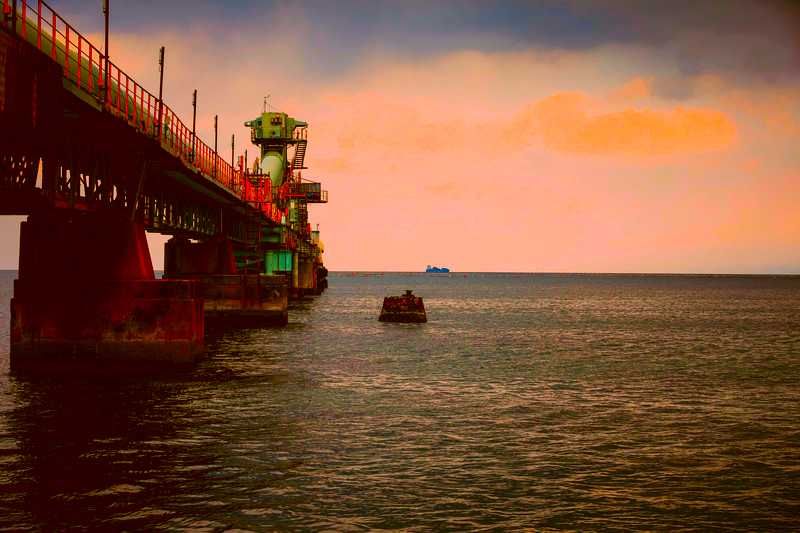

In [17]:
Image.fromarray(img2)

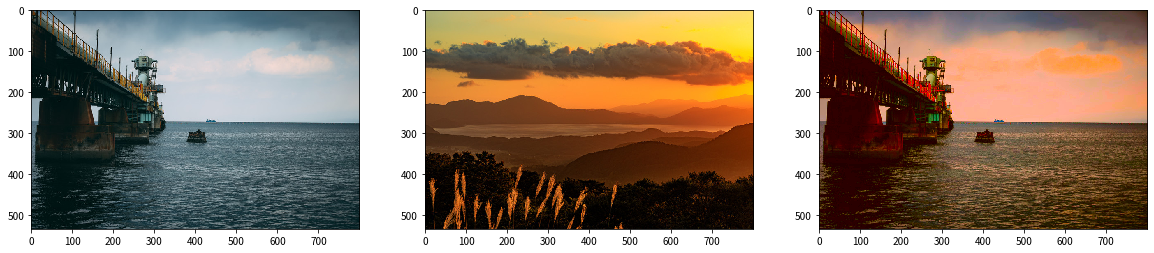

In [18]:
fig, axs = plt.subplots(1,3, figsize=(20,20))

axs[0].imshow(Image.fromarray(source))
axs[1].imshow(Image.fromarray(target))
axs[2].imshow(Image.fromarray(img2))

画像によっては変換後画像の雲や橋のように不自然な色が出力されることもある.

## 発展的話題

target 画像の全体的な平均, 標準偏差を使うので, 人が想像したのとは異なる画像が出力されることもある.


https://www.pyimagesearch.com/2014/06/30/super-fast-color-transfer-images/

ここでは target の一部の平均,標準偏差を使用することや, k-means で2つの画像の類似した点での変換が提案されている.

## 参考資料

- https://stackoverflow.com/questions/16798771/numpy-dot-product
- https://qiita.com/wkiino/items/f4a8f340016951107646
- https://www.pyimagesearch.com/2014/06/30/super-fast-color-transfer-images/